Mohammadreza Jamalifard - 2022 (C) All rights reserved
I would like to acknolweldege the authors of [Norm-Explicit Quantization: Improving Vector
Quantization for Maximum Inner Product Search] [2020], from where parts of their source code was recycled for this work.

In [2]:
import numpy as np
import struct
from __future__ import division
from __future__ import print_function
from scipy.stats import ortho_group
import numba as nb
from scipy.cluster.vq import kmeans2, vq
import warnings
import math
import tqdm
from fcmeans import FCM
from multiprocessing import cpu_count
import time
import matplotlib.pyplot as plt

In [301]:
@nb.jit
def arg_sort(distances):
    top_k = min(131072, len(distances)-1)
    indices = np.argpartition(distances, top_k)[:top_k]
    return indices[np.argsort(distances[indices])]


@nb.jit
def product_arg_sort(q, compressed):
    distances = np.dot(compressed, -q)
    return arg_sort(distances)


@nb.jit
def angular_arg_sort(q, compressed, norms_sqr):
    norm_q = np.linalg.norm(q)
    distances = np.dot(compressed, q) / (norm_q * norms_sqr)
    return arg_sort(distances)


@nb.jit
def euclidean_arg_sort(q, compressed):
    distances = np.linalg.norm(q - compressed, axis=1)
    return arg_sort(distances)


@nb.jit
def sign_arg_sort(q, compressed):
    distances = np.empty(len(compressed), dtype=np.int32)
    for i in range(len(compressed)):
        distances[i] = np.count_nonzero((q > 0) != (compressed[i] > 0))
    return arg_sort(distances)


@nb.jit
def euclidean_norm_arg_sort(q, compressed, norms_sqr):
    distances = norms_sqr - 2.0 * np.dot(compressed, q)
    return arg_sort(distances)


@nb.jit
def parallel_sort(metric, compressed, Q, X, norms_sqr=None):
    """
    for each q in 'Q', sort the compressed items in 'compressed' by their distance,
    where distance is determined by 'metric'
    :param metric: euclid product
    :param compressed: compressed items, same dimension as origin data, shape(N * D)
    :param Q: queries, shape(len(Q) * D)
    :return:
    """

    rank = np.empty((Q.shape[0], min(131072, compressed.shape[0]-1)), dtype=np.int32)

    p_range = tqdm.tqdm(nb.prange(Q.shape[0]))

    if metric == 'product':
        for i in p_range:
            rank[i, :] = product_arg_sort(Q[i], compressed)
    elif metric == 'angular':
        if norms_sqr is None:
            norms_sqr = np.linalg.norm(compressed, axis=1) ** 2
        for i in p_range:
            rank[i, :] = angular_arg_sort(Q[i], compressed, norms_sqr)
    elif metric == 'euclid_norm':
        if norms_sqr is None:
            norms_sqr = np.linalg.norm(compressed, axis=1) ** 2
        for i in p_range:
            rank[i, :] = euclidean_norm_arg_sort(Q[i], compressed, norms_sqr)
    else:
        for i in p_range:
            rank[i, :] = euclidean_arg_sort(Q[i], compressed)

    return rank


@nb.jit
def true_positives(topK, Q, G, T):
    result = np.empty(shape=(len(Q)))
    for i in nb.prange(len(Q)):
        result[i] = len(np.intersect1d(G[i], topK[i][:T]))
    return result


class Sorter(object):
    def __init__(self, compressed, Q, X, metric, norms_sqr=None):
        self.Q = Q
        self.X = X

        self.topK = parallel_sort(metric, compressed, Q, X, norms_sqr=norms_sqr)

    def recall(self, G, T):
        t = min(T, len(self.topK[0]))
        return t, self.sum_recall(G, T) / len(self.Q)

    def sum_recall(self, G, T):
        assert len(self.Q) == len(self.topK), "number of query not equals"
        assert len(self.topK) <= len(G), "number of queries should not exceed the number of queries in ground truth"
        true_positive = true_positives(self.topK, self.Q, G, T)
        return np.sum(true_positive) / len(G[0])  # TP / K


class BatchSorter(object):
    def __init__(self, compressed, Q, X, G, Ts, metric, batch_size, norms_sqr=None):
        self.Q = Q
        self.X = X
        self.recalls = np.zeros(shape=(len(Ts)))
        for i in range(math.ceil(len(Q) / float(batch_size))):
            q = Q[i*batch_size: (i + 1) * batch_size, :]
            g = G[i*batch_size: (i + 1) * batch_size, :]
            sorter = Sorter(compressed, q, X, metric=metric, norms_sqr=norms_sqr)
            self.recalls[:] = self.recalls[:] + [sorter.sum_recall(g, t) for t in Ts]
        self.recalls = self.recalls / len(self.Q)

    def recall(self):
        return self.recalls


In [302]:
class PQ(object):
    def __init__(self, M, Ks, verbose=True):
        assert 0 < Ks <= 2 ** 32
        self.M, self.Ks, self.verbose = M, Ks, verbose
        self.code_dtype = np.uint8 if Ks <= 2 ** 8 else (np.uint16 if Ks <= 2 ** 16 else np.uint32)
        self.codewords = None
        self.Ds = None
        self.Dim = -1

    def class_message(self):
        return "Subspace PQ, M: {}, Ks : {}, code_dtype: {}".format(self.M, self.Ks, self.code_dtype)

    def fit(self, vecs, iter):
        assert vecs.dtype == np.float32
        assert vecs.ndim == 2
        N, D = vecs.shape
        assert self.Ks < N, "the number of training vector should be more than Ks"
        self.Dim = D

        reminder = D % self.M
        quotient = int(D / self.M)
        dims_width = [quotient + 1 if i < reminder else quotient for i in range(self.M)]
        self.Ds = np.cumsum(dims_width)     # prefix sum
        self.Ds = np.insert(self.Ds, 0, 0)  # insert zero at beginning

        # [m][ks][ds]: m-th subspace, ks-the codeword, ds-th dim
        self.codewords = np.zeros((self.M, self.Ks, np.max(dims_width)), dtype=np.float32)
        for m in range(self.M):
            if self.verbose:
                print("#    Training the subspace: {} / {}, {} -> {}".format(m, self.M, self.Ds[m], self.Ds[m+1]))
            vecs_sub = vecs[:, self.Ds[m]:self.Ds[m+1]]
            self.codewords[m, :, :self.Ds[m+1] - self.Ds[m]], _ = kmeans2(
                vecs_sub, self.Ks, iter=iter, minit='points')

        return self

    def encode(self, vecs):
        assert vecs.dtype == np.float32
        assert vecs.ndim == 2
        N, D = vecs.shape

        # codes[n][m] : code of n-th vec, m-th subspace
        codes = np.empty((N, self.M), dtype=self.code_dtype)
        for m in range(self.M):
            vecs_sub = vecs[:, self.Ds[m]: self.Ds[m+1]]
            codes[:, m], _ = vq(vecs_sub,
                                self.codewords[m, :, :self.Ds[m+1] - self.Ds[m]])

        return codes

    def decode(self, codes):
        assert codes.ndim == 2
        N, M = codes.shape
        assert M == self.M
        assert codes.dtype == self.code_dtype

        vecs = np.empty((N, self.Dim), dtype=np.float32)
        for m in range(self.M):
            vecs[:, self.Ds[m]: self.Ds[m+1]] = self.codewords[m, codes[:, m], :self.Ds[m+1] - self.Ds[m]]

        return vecs

    def compress(self, vecs):
        return self.decode(self.encode(vecs))


In [303]:
class PQ(object):
    def __init__(self, M, Ks, verbose=True):
        assert 0 < Ks <= 2 ** 32
        self.M, self.Ks, self.verbose = M, Ks, verbose
        self.code_dtype = np.uint8 if Ks <= 2 ** 8 else (np.uint16 if Ks <= 2 ** 16 else np.uint32)
        self.codewords = None
        self.Ds = None
        self.Dim = -1

    def class_message(self):
        return "Subspace PQ, M: {}, Ks : {}, code_dtype: {}".format(self.M, self.Ks, self.code_dtype)

    def fit(self, vecs, iter):
        assert vecs.dtype == np.float32
        assert vecs.ndim == 2
        N, D = vecs.shape
        assert self.Ks < N, "the number of training vector should be more than Ks"
        self.Dim = D

        reminder = D % self.M
        quotient = int(D / self.M)
        dims_width = [quotient + 1 if i < reminder else quotient for i in range(self.M)]
        self.Ds = np.cumsum(dims_width)     # prefix sum
        self.Ds = np.insert(self.Ds, 0, 0)  # insert zero at beginning

        # [m][ks][ds]: m-th subspace, ks-the codeword, ds-th dim
        self.codewords = np.zeros((self.M, self.Ks, np.max(dims_width)), dtype=np.float32)
        for m in range(self.M):
            if self.verbose:
                print("#    Training the subspace: {} / {}, {} -> {}".format(m, self.M, self.Ds[m], self.Ds[m+1]))
            vecs_sub = vecs[:, self.Ds[m]:self.Ds[m+1]]
            self.codewords[m, :, :self.Ds[m+1] - self.Ds[m]], _ = kmeans2(
                vecs_sub, self.Ks, iter=iter, minit='points')

        return self

    def encode(self, vecs):
        assert vecs.dtype == np.float32
        assert vecs.ndim == 2
        N, D = vecs.shape

        # codes[n][m] : code of n-th vec, m-th subspace
        codes = np.empty((N, self.M), dtype=self.code_dtype)
        for m in range(self.M):
            vecs_sub = vecs[:, self.Ds[m]: self.Ds[m+1]]
            codes[:, m], _ = vq(vecs_sub,
                                self.codewords[m, :, :self.Ds[m+1] - self.Ds[m]])

        return codes

    def decode(self, codes):
        assert codes.ndim == 2
        N, M = codes.shape
        assert M == self.M
        assert codes.dtype == self.code_dtype

        vecs = np.empty((N, self.Dim), dtype=np.float32)
        for m in range(self.M):
            vecs[:, self.Ds[m]: self.Ds[m+1]] = self.codewords[m, codes[:, m], :self.Ds[m+1] - self.Ds[m]]

        return vecs

    def compress(self, vecs):
        return self.decode(self.encode(vecs))


In [304]:

def normalize(vecs):
    norms = np.linalg.norm(vecs, axis=1)
    norms_matrix = norms[:, np.newaxis]
    normalized_vecs = np.divide(vecs, norms_matrix, out=np.zeros_like(vecs), where=norms_matrix != 0)  # divide by zero problem
    return norms, normalized_vecs


def zero_mean(X, Q):
    mean = X.mean(axis=0, keepdims=True)
    X = X - mean
    Q = Q - mean
    return X, Q


def random_rotate(X, Q):
    R = ortho_group.rvs(dim=len(X[0]))
    R = np.array(R, dtype=np.float32)
    X = R.dot(X.transpose()).transpose()
    Q = R.dot(Q.transpose()).transpose()
    return X, Q


def scale(X, Q):
    scale = np.max(np.linalg.norm(X, axis=1))
    X /= scale
    Q /= scale
    return X, Q


def one_half_coeff_scale(X, Q):
    mean = np.mean(np.absolute(X))
    X /= (mean * 2);
    Q /= (mean * 2);
    return X, Q

def coeff_scale(X, Q, scale):
    mean = np.mean(np.absolute(X))
    X /= (mean / scale);
    Q /= (mean / scale);
    return X, Q

def inverse_d_coeff_scale(X, Q):
    mean = np.mean(np.absolute(X))
    X /= (mean * X.shape[1]);
    Q /= (mean * X.shape[1])
    return X, Q

@nb.jit(nopython=True)
def norm_range(norm_sqrs, num_intervals):
    num_intervals_minus_1 = float(num_intervals - 1)

    norm_sqr_max = np.amax(norm_sqrs)
    norm_sqr_min = np.amin(norm_sqrs)

    means = np.empty((norm_sqrs.shape[0]), dtype=np.float32)

    for i in range(norm_sqrs.shape[0]):
        bucket = int((norm_sqrs[i] - norm_sqr_min) / (norm_sqr_max - norm_sqr_min) * num_intervals_minus_1)
        left = bucket / num_intervals_minus_1 * (norm_sqr_max - norm_sqr_min) + norm_sqr_min
        right = (bucket + 1) / num_intervals_minus_1 * (norm_sqr_max - norm_sqr_min) + norm_sqr_min
        mean = (left + right) / 2.0

        means[i] = mean

    return means

def norm_range_non_uniform(norm_sqrs):
    code_book, code = kmeans2(norm_sqrs[:, np.newaxis], 256, iter=20, minit='points')
    return code_book[code, 0]

def e2m_transform(X, Q):
    M = np.max(np.linalg.norm(X, axis=1))
    X_plus = np.zeros((len(X), 4), dtype=np.float32)
    Q_plus = np.zeros((len(Q), 4), dtype=np.float32)

    X_plus[:, 0] = M - np.linalg.norm(X, axis=1) ** 2
    Q_plus[:, 0] = 0.5
    X = np.append(X, X_plus, axis=1)
    Q = np.append(Q, Q_plus, axis=1)
    return X, Q


def e2m_mahalanobis(X):
    X_plus = np.full((len(X), 1), fill_value=-0.5, dtype=np.float32)
    X = np.append(X, X_plus, axis=1)
    return np.dot(X.transpose(), X) / float(len(X))


In [305]:
class NormPQ(object):
    def __init__(self, n_percentile, quantize, true_norm=False, verbose=True, method='kmeans', recover='quantize'):

        self.M = 2
        self.n_percentile, self.true_norm, self.verbose = n_percentile, true_norm, verbose
        self.method = method
        self.recover = recover
        self.code_dtype = np.uint8 if n_percentile <= 2 ** 8 \
            else (np.uint16 if n_percentile <= 2 ** 16 else np.uint32)

        self.percentiles = None
        self.quantize = quantize

    def class_message(self):
        return "NormPQ, percentiles: {}, quantize: {}".format(self.n_percentile, self.quantize.class_message())

    def fit(self, vecs, iter):
        assert vecs.dtype == np.float32
        assert vecs.ndim == 2
        N, D = vecs.shape
        assert self.n_percentile < N, "the number of norm intervals should be more than Ks"

        norms, normalized_vecs = normalize(vecs)
        self.quantize.fit(normalized_vecs, iter)

        if self.recover == 'quantize':
            compressed_vecs = self.quantize.compress(normalized_vecs)
            norms = norms / np.linalg.norm(compressed_vecs, axis=1)
            
        elif self.recover == 'normalization':
            warnings.warn("Recover norm by normalization.")
            assert False
        else:
            warnings.warn("No normalization guarantee.")
            assert False

        if self.method == 'kmeans':
            print(norms)
            self.percentiles, _ = kmeans2(norms[:], self.n_percentile, iter=iter, minit='points')
        elif self.method == 'kmeans_partial':
            indexes = np.argsort(norms)
            count = int(len(norms) * 0.7)
            centers_small_norms, _ = kmeans2(norms[indexes[:count]], self.n_percentile // 2, iter=iter, minit='points')
            centers_big_norms, _ = kmeans2(norms[indexes[count:]], self.n_percentile // 2, iter=iter, minit='points')
            self.percentiles = np.concatenate((centers_small_norms, centers_big_norms))

        elif self.method == 'percentile':
            self.percentiles = np.percentile(norms, np.linspace(0, 100, self.n_percentile + 1)[:])
            self.percentiles = np.array(self.percentiles, dtype=np.float32)
        elif self.method == 'fcm':
            normv2 = np.reshape(norms, (-1, 2))
            fcm_model = FCM(n_clusters = self.n_percentile, max_iter = iter)
            fcm_model.fit(normv2)
            self.percentiles = (fcm_model.centers[:,0] + fcm_model.centers[:,1])/2
            np.savetxt('centers.txt',fcm_model.centers)
            np.savetxt("file.txt",self.percentiles)
        elif self.method == 'exponential':
            q = 0.98
            a = (1 - q) / (1 - q**self.n_percentile)  # make sure that sum of a*q**i is 1
            self.percentiles = [
                np.min(norms) if i == 0 else
                np.min(norms) + a * (1 - q**i) / (1 - q) * (np.max(norms) - np.min(norms))
                for i in range(self.n_percentile + 1)
            ]

            self.percentiles = np.array(self.percentiles, dtype=np.float32)
        else:
            assert False

        return self

    def encode_norm(self, norms):

        if self.method == 'kmeans' or self.method == 'kmeans_partial':
            norm_index, _ = vq(norms[:], self.percentiles)
        else:
            norm_index = [np.argmax(self.percentiles[1:] > n) for n in norms]
            norm_index = np.clip(norm_index, 1, self.n_percentile)
        return norm_index

    def decode_norm(self, norm_index):
        if self.method == 'kmeans' or self.method == 'kmeans_partial' or self.method=='fcm':
            return self.percentiles[norm_index]
        else:
            return (self.percentiles[norm_index]+self.percentiles[norm_index-1]) / 2.0

    def compress(self, vecs):
        norms, normalized_vecs = normalize(vecs)

        compressed_vecs = self.quantize.compress(normalized_vecs)
        del normalized_vecs

        if self.recover == 'quantize':
            norms = norms / np.linalg.norm(compressed_vecs, axis=1)
        elif self.recover == 'normalization':
            warnings.warn("Recover norm by normalization.")
            _, compressed_vecs = normalize(compressed_vecs)
            assert False
        else:
            warnings.warn("No normalization guarantee.")
            assert False

        if not self.true_norm:
            norms = self.decode_norm(self.encode_norm(norms))
        else:
            warnings.warn("Using true norm to compress vector.")
            assert False

        return (compressed_vecs.transpose() * norms).transpose()



In [306]:
class ResidualPQ(object):
    def __init__(self, pqs=None, verbose=True):

        assert len(pqs) > 0
        self.verbose = verbose
        self.deep = len(pqs)
        self.code_dtype = pqs[0].code_dtype
        self.M = max([pq.M for pq in pqs])
        self.pqs = pqs

        for pq in self.pqs:
            assert pq.code_dtype == self.code_dtype

    def class_message(self):
        messages = ""
        for i, pq in enumerate(self.pqs):
            messages += pq.class_message()
        return messages

    def fit(self, T, iter, save_codebook=False, save_decoded=[], save_residue_norms=[], save_results_T=False, dataset_name=None, save_dir=None, D=None):
        assert T.dtype == np.float32
        assert T.ndim == 2

        if save_dir is None:
            save_dir = './results'

        vecs = np.empty(shape=T.shape, dtype=T.dtype)
        vecs[:, :] = T[:, :]
        if D is not None:
            vecs_d = np.empty(shape=D.shape, dtype=D.dtype)
            vecs_d[:, :] = D[:, :]
        if save_codebook:
            codebook_f = open(save_dir + '/' + dataset_name + '_rq_' + str(self.deep) + '_' + str(self.pqs[0].Ks) + '_codebook', 'wb')

        for layer, pq in enumerate(self.pqs):
            pq.fit(vecs, iter)
            compressed = pq.compress(vecs)
            vecs = vecs - compressed
            del compressed

            if D is not None:
                compressed_d = pq.compress(vecs_d)
                vecs_d -= compressed_d

            if self.verbose:
                norms = np.linalg.norm(vecs, axis=1)
                print("# layer: {},  residual average norm : {} max norm: {} min norm: {}"
                      .format(layer, np.mean(norms), np.max(norms), np.min(norms)))

            if (layer + 1) in save_residue_norms:
                with open(save_dir + '/' + dataset_name + '_rq_' + str(layer + 1) + '_' + str(self.pqs[0].Ks) + '_residue_norms', 'wb') as f:
                    if save_results_T:
                        np.linalg.norm(vecs, axis=1).tofile(f)
                    if D is not None:
                        np.linalg.norm(vecs_d, axis=1).tofile(f)

            if (layer + 1) in save_decoded:
                with open(save_dir + '/' + dataset_name + '_rq_' + str(layer + 1) + '_' + str(self.pqs[0].Ks) + '_decoded', 'wb') as f:
                    if save_results_T:
                        (T - vecs).tofile(f)
                    if D is not None:
                        (D - vecs_d).tofile(f)

            if save_codebook:
                pq.codewords.tofile(codebook_f)
                codebook_f.flush()

        if save_codebook:
            codebook_f.close()

        return self

    def encode(self, vecs):
        """
        :param vecs:
        :return: (N * deep * M)
        """
        codes = np.zeros((len(vecs), self.deep, self.M), dtype=self.code_dtype)  # N * deep * M
        for i, pq in enumerate(self.pqs):
            codes[:, i, :pq.M] = pq.encode(vecs)
            vecs = vecs - pq.decode(codes[:, i, :pq.M])
        return codes  # N * deep * M

    def decode(self, codes):
        vecss = [pq.decode(codes[:, i, :pq.M]) for i, pq in enumerate(self.pqs)]
        return np.sum(vecss, axis=0)

    def compress(self, X):
        N, D = np.shape(X)

        sum_residual = np.zeros((N, D), dtype=X.dtype)

        vecs = np.zeros((N, D), dtype=X.dtype)
        vecs[:, :] = X[:, :]

        for i, pq in enumerate(self.pqs):
            compressed = pq.compress(vecs)
            vecs[:, :] = vecs - compressed
            sum_residual[:, :] = sum_residual + compressed
            del compressed

        return sum_residual

In [307]:
def ivecs_read(fname):
    a = np.fromfile(fname, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy()


def fvecs_read(fname):
    return ivecs_read(fname).view('float32')


def bvecs_read(fname):
    a = np.fromfile(fname, dtype='uint8')
    d = a[:4].view('uint8')[0]
    return a.reshape(-1, d + 4)[:, 4:].copy()


# we mem-map the biggest files to avoid having them in memory all at
# once
def mmap_fvecs(fname):
    x = np.memmap(fname, dtype='int32', mode='r')
    d = x[0]
    return x.view('float32').reshape(-1, d + 1)[:, 1:]


def mmap_bvecs(fname):
    x = np.memmap(fname, dtype='uint8', mode='r')
    d = x[:4].view('int32')[0]
    return x.reshape(-1, d + 4)[:, 4:]


def bvecs_read(filename):
    return mmap_bvecs(fname=filename)


def fvecs_writer(filename, vecs):
    f = open(filename, "ab")
    dimension = [len(vecs[0])]

    for x in vecs:
        f.write(struct.pack('i' * len(dimension), *dimension))
        f.write(struct.pack('f' * len(x), *x))

    f.close()


def ivecs_writer(filename, vecs):
    f = open(filename, "ab")
    dimension = [len(vecs[0])]

    for x in vecs:
        f.write(struct.pack('i' * len(dimension), *dimension))
        f.write(struct.pack('i' * len(x), *x))

    f.close()


def loader(data_set='audio', top_k=20, ground_metric='euclid', folder='../data/', data_type='fvecs'):
    """
    :param data_set: data set you wanna load , audio, sift1m, ..
    :param top_k: how many nearest neighbor in ground truth file
    :param ground_metric:
    :param folder:
    :return: X, T, Q, G
    """
    folder_path = folder + data_set
    base_file = folder_path + '/%s_base.%s' % (data_set, data_type)
    train_file = folder_path + '/%s_learn.%s' % (data_set, data_type)
    query_file = folder_path + '/%s_query.%s' % (data_set, data_type)
    ground_truth = folder_path + '/%s_%s_%s_groundtruth.ivecs' % \
                   (top_k, data_set, ground_metric)

    print("# load the base data {}, \n# load the queries {}, \n# load the ground truth {}".format(base_file, query_file,
                                                                                            ground_truth))
    if data_type == 'fvecs':
        X = fvecs_read(base_file)
        Q = fvecs_read(query_file)
        try:
            T = fvecs_read(train_file)
        except FileNotFoundError:
            T = None
    elif data_type == 'bvecs':
        X = bvecs_read(base_file).astype(np.float32)
        Q = bvecs_read(query_file).astype(np.float32)
        try:
            T = bvecs_read(train_file)
        except FileNotFoundError:
            T = None
    else:
        assert False
    try:
        G = ivecs_read(ground_truth)
    except FileNotFoundError:
        G = None
    return X, T, Q, G


In [308]:
def chunk_compress(pq, vecs):
    chunk_size = 11700
    compressed_vecs = np.empty(shape=vecs.shape, dtype=np.float32)
    for i in tqdm.tqdm(range(math.ceil(len(vecs) / chunk_size))):
        compressed_vecs[i * chunk_size: (i + 1) * chunk_size, :] \
            = pq.compress(vecs[i * chunk_size: (i + 1) * chunk_size, :].astype(dtype=np.float32))
    return compressed_vecs


def execute(pq, X, T, Q, G, metric, train_size=11700):
    np.random.seed(123)
    np.random.shuffle(X)
    print("# ranking metric {}".format(metric))
    print("# "+pq.class_message())
    if T is None:
        pq.fit(X[:train_size].astype(dtype=np.float32), iter=20)
    else:
        pq.fit(T.astype(dtype=np.float32), iter=20)

    print('# compress items')
    compressed = chunk_compress(pq, X)
    print("# sorting items")
    Ts = [2 ** i for i in range(2+int(math.log2(len(X))))]
    recalls = BatchSorter(compressed, Q, X, G, Ts, metric=metric, batch_size=200).recall()
    print("# searching!")
    recall_item_curve = []
    print("expected items, overall time, avg recall, avg precision, avg error, avg items")
    for i, (t, recall) in enumerate(zip(Ts, recalls)):
        print("{}, {}, {}, {}, {}, {}".format(
            2**i, 0, recall, recall * len(G[0]) / t, 0, t))
        recall_item_curve.append(recall)
    return recall_item_curve, recalls

def parse_args():
    # override default parameters with command line parameters
    import argparse
    parser = argparse.ArgumentParser(description='Process input method and parameters.')
    parser.add_argument('--dataset', type=str, help='choose data set name')
    parser.add_argument('--topk', type=int, help='required topk of ground truth')
    parser.add_argument('--metric', type=str, help='metric of ground truth')
    parser.add_argument('--num_codebook', type=int, help='number of codebooks')
    parser.add_argument('--Ks', type=int, help='number of centroids in each quantizer')
    args = parser.parse_args()
    return args.dataset, args.topk, args.num_codebook, args.Ks, args.metric

In [417]:
average_time = list(range(0,4))
average_std = list(range(0,4))
recall_Set = []

In [436]:
if __name__ == '__main__':
    ks = [32, 32, 100, 100]
    cs = [8, 16, 32, 128]
    pi = 3
    dataset = 'netflix'
    topk = 20
    codebook = cs[pi]
    Ks = ks[pi]
    metric = 'product'

    # override default parameters with command line parameters
    import sys
    if len(sys.argv) > 3:
        dataset, topk, codebook, Ks, metric = parse_args()
    else:
        import warnings
        warnings.warn("Using  Default Parameters ")
    print("# Parameters: dataset = {}, topK = {}, codebook = {}, Ks = {}, metric = {}"
          .format(dataset, topk, codebook, Ks, metric))


    X, T, Q, G = loader(dataset, topk, metric, folder='data/')
    # pq, rq, or component of norm-pq
    recall_item_curve = np.zeros((10,16))
    time_list = []
    for i in range(0,10):
        quantizer = NormPQ(n_percentile=Ks, quantize=PQ(M=codebook-1, Ks=Ks), method='kmeans')
        start_time = time.time()
        recall_item_curve[i,:], recalls = execute(quantizer,  X, T, Q, G, metric)
        print("--- %s seconds ---, iteration %s" % (time.time() - start_time,i+1))
        time_list.append(time.time() - start_time)
    

C:\Users\mrjmf\AppData\Local\Temp\ipykernel_9092\1419328588.py:17: UserWarning: Using  Default Parameters 
  warnings.warn("Using  Default Parameters ")


# Parameters: dataset = netflix, topK = 20, codebook = 128, Ks = 100, metric = product
# load the base data data/netflix/netflix_base.fvecs, 
# load the queries data/netflix/netflix_query.fvecs, 
# load the ground truth data/netflix/20_netflix_product_groundtruth.ivecs
# ranking metric product
# NormPQ, percentiles: 100, quantize: Subspace PQ, M: 127, Ks : 100, code_dtype: <class 'numpy.uint8'>
#    Training the subspace: 0 / 127, 0 -> 3
#    Training the subspace: 1 / 127, 3 -> 6
#    Training the subspace: 2 / 127, 6 -> 9
#    Training the subspace: 3 / 127, 9 -> 12
#    Training the subspace: 4 / 127, 12 -> 15
#    Training the subspace: 5 / 127, 15 -> 18
#    Training the subspace: 6 / 127, 18 -> 21
#    Training the subspace: 7 / 127, 21 -> 24
#    Training the subspace: 8 / 127, 24 -> 27
#    Training the subspace: 9 / 127, 27 -> 30
#    Training the subspace: 10 / 127, 30 -> 33
#    Training the subspace: 11 / 127, 33 -> 36
#    Training the subspace: 12 / 127, 36 -> 39
#    Tra

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[1.6637609 1.9822999 1.9080894 ... 1.8720485 1.9957652 2.0081244]
# compress items


 20%|████████████████▍                                                               | 41/200 [00:00<00:00, 369.83it/s]

# sorting items


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 379.54it/s]


# searching!
expected items, overall time, avg recall, avg precision, avg error, avg items
1, 0, 0.0, 0.0, 0, 1
2, 0, 0.0002, 0.002, 0, 2
4, 0, 0.00025, 0.00125, 0, 4
8, 0, 0.00055, 0.0013750000000000001, 0, 8
16, 0, 0.00145, 0.0018124999999999999, 0, 16
32, 0, 0.0021000000000000003, 0.0013125000000000003, 0, 32
64, 0, 0.00425, 0.001328125, 0, 64
128, 0, 0.011600000000000001, 0.0018125, 0, 128
256, 0, 0.030600000000000002, 0.0023906250000000004, 0, 256
512, 0, 0.060899999999999996, 0.00237890625, 0, 512
1024, 0, 0.10085, 0.0019697265625, 0, 1024
2048, 0, 0.1505, 0.0014697265625, 0, 2048
4096, 0, 0.24694999999999998, 0.0012058105468749998, 0, 4096
8192, 0, 0.43605, 0.0010645751953125, 0, 8192
16384, 0, 0.89645, 0.00109429931640625, 0, 16384
32768, 0, 1.0, 0.0006103515625, 0, 32768
--- 17.468788862228394 seconds ---, iteration 1
# ranking metric product
# NormPQ, percentiles: 100, quantize: Subspace PQ, M: 127, Ks : 100, code_dtype: <class 'numpy.uint8'>
#    Training the subspace: 0 / 1

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[1.5786501 1.2892648 1.7862048 ... 1.7735262 1.9233481 1.8794478]
# compress items


 21%|████████████████▊                                                               | 42/200 [00:00<00:00, 377.39it/s]

# sorting items


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 369.20it/s]


# searching!
expected items, overall time, avg recall, avg precision, avg error, avg items
1, 0, 0.0, 0.0, 0, 1
2, 0, 0.0, 0.0, 0, 2
4, 0, 0.0, 0.0, 0, 4
8, 0, 5e-05, 0.000125, 0, 8
16, 0, 0.00025, 0.0003125, 0, 16
32, 0, 0.0007, 0.0004375, 0, 32
64, 0, 0.004399999999999999, 0.001375, 0, 64
128, 0, 0.01015, 0.0015859374999999999, 0, 128
256, 0, 0.0174, 0.001359375, 0, 256
512, 0, 0.0356, 0.001390625, 0, 512
1024, 0, 0.07765000000000001, 0.0015166015625000002, 0, 1024
2048, 0, 0.15925, 0.00155517578125, 0, 2048
4096, 0, 0.27795, 0.0013571777343749998, 0, 4096
8192, 0, 0.5028, 0.0012275390625000001, 0, 8192
16384, 0, 0.9338, 0.001139892578125, 0, 16384
32768, 0, 1.0, 0.0006103515625, 0, 32768
--- 17.3514506816864 seconds ---, iteration 2
# ranking metric product
# NormPQ, percentiles: 100, quantize: Subspace PQ, M: 127, Ks : 100, code_dtype: <class 'numpy.uint8'>
#    Training the subspace: 0 / 127, 0 -> 3
#    Training the subspace: 1 / 127, 3 -> 6
#    Training the subspace: 2 / 127, 6

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[1.8164606 1.6789181 1.7478566 ... 1.9829704 2.1905015 1.9070829]
# compress items


 20%|████████████████                                                                | 40/200 [00:00<00:00, 360.89it/s]

# sorting items


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 378.42it/s]


# searching!
expected items, overall time, avg recall, avg precision, avg error, avg items
1, 0, 0.0, 0.0, 0, 1
2, 0, 0.0001, 0.001, 0, 2
4, 0, 0.0004, 0.002, 0, 4
8, 0, 0.00125, 0.003125, 0, 8
16, 0, 0.0023000000000000004, 0.0028750000000000004, 0, 16
32, 0, 0.0038, 0.002375, 0, 32
64, 0, 0.0070999999999999995, 0.00221875, 0, 64
128, 0, 0.010899999999999998, 0.0017031249999999998, 0, 128
256, 0, 0.01425, 0.0011132812500000001, 0, 256
512, 0, 0.0197, 0.0007695312499999999, 0, 512
1024, 0, 0.0316, 0.0006171875000000001, 0, 1024
2048, 0, 0.07490000000000001, 0.0007314453125000001, 0, 2048
4096, 0, 0.19865, 0.000969970703125, 0, 4096
8192, 0, 0.43545, 0.0010631103515625, 0, 8192
16384, 0, 0.86295, 0.00105340576171875, 0, 16384
32768, 0, 1.0, 0.0006103515625, 0, 32768
--- 17.30119490623474 seconds ---, iteration 3
# ranking metric product
# NormPQ, percentiles: 100, quantize: Subspace PQ, M: 127, Ks : 100, code_dtype: <class 'numpy.uint8'>
#    Training the subspace: 0 / 127, 0 -> 3
#    T

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[1.2555978 1.639479  2.084355  ... 2.0040414 1.7089437 2.149823 ]
# compress items


 20%|████████████████                                                                | 40/200 [00:00<00:00, 354.42it/s]

# sorting items


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 359.13it/s]


# searching!
expected items, overall time, avg recall, avg precision, avg error, avg items
1, 0, 0.0, 0.0, 0, 1
2, 0, 0.0, 0.0, 0, 2
4, 0, 0.0, 0.0, 0, 4
8, 0, 0.00025, 0.000625, 0, 8
16, 0, 0.0004999999999999999, 0.0006249999999999999, 0, 16
32, 0, 0.0014, 0.000875, 0, 32
64, 0, 0.0025999999999999994, 0.0008124999999999999, 0, 64
128, 0, 0.004900000000000001, 0.0007656250000000001, 0, 128
256, 0, 0.00785, 0.0006132812499999999, 0, 256
512, 0, 0.0152, 0.00059375, 0, 512
1024, 0, 0.04275, 0.0008349609375000001, 0, 1024
2048, 0, 0.13190000000000002, 0.0012880859375000002, 0, 2048
4096, 0, 0.26630000000000004, 0.0013002929687500001, 0, 4096
8192, 0, 0.487, 0.00118896484375, 0, 8192
16384, 0, 0.9148499999999999, 0.0011167602539062498, 0, 16384
32768, 0, 1.0, 0.0006103515625, 0, 32768
--- 17.47195816040039 seconds ---, iteration 4
# ranking metric product
# NormPQ, percentiles: 100, quantize: Subspace PQ, M: 127, Ks : 100, code_dtype: <class 'numpy.uint8'>
#    Training the subspace: 0 / 12

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[1.7377948 1.3198137 1.759164  ... 2.0600932 2.0606556 1.7329253]
# compress items


 20%|████████████████▍                                                               | 41/200 [00:00<00:00, 371.56it/s]

# sorting items


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 367.34it/s]


# searching!
expected items, overall time, avg recall, avg precision, avg error, avg items
1, 0, 0.0, 0.0, 0, 1
2, 0, 0.0, 0.0, 0, 2
4, 0, 0.0, 0.0, 0, 4
8, 0, 0.0, 0.0, 0, 8
16, 0, 5e-05, 6.25e-05, 0, 16
32, 0, 0.0001, 6.25e-05, 0, 32
64, 0, 0.00025, 7.8125e-05, 0, 64
128, 0, 0.00065, 0.0001015625, 0, 128
256, 0, 0.0022, 0.00017187500000000002, 0, 256
512, 0, 0.0077, 0.00030078125, 0, 512
1024, 0, 0.024849999999999997, 0.00048535156249999994, 0, 1024
2048, 0, 0.06520000000000001, 0.0006367187500000001, 0, 2048
4096, 0, 0.19615, 0.000957763671875, 0, 4096
8192, 0, 0.47735, 0.0011654052734375, 0, 8192
16384, 0, 0.9264499999999999, 0.0011309204101562498, 0, 16384
32768, 0, 1.0, 0.0006103515625, 0, 32768
--- 17.425189971923828 seconds ---, iteration 5
# ranking metric product
# NormPQ, percentiles: 100, quantize: Subspace PQ, M: 127, Ks : 100, code_dtype: <class 'numpy.uint8'>
#    Training the subspace: 0 / 127, 0 -> 3
#    Training the subspace: 1 / 127, 3 -> 6
#    Training the subspac

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[1.9127755 1.8760579 1.6213024 ... 1.8467962 1.4553537 1.8378358]
# compress items


 20%|███████████████▌                                                                | 39/200 [00:00<00:00, 351.61it/s]

# sorting items


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 367.19it/s]


# searching!
expected items, overall time, avg recall, avg precision, avg error, avg items
1, 0, 0.0, 0.0, 0, 1
2, 0, 0.0, 0.0, 0, 2
4, 0, 0.0, 0.0, 0, 4
8, 0, 0.0001, 0.00025, 0, 8
16, 0, 0.0001, 0.000125, 0, 16
32, 0, 0.00065, 0.00040625, 0, 32
64, 0, 0.0036999999999999997, 0.00115625, 0, 64
128, 0, 0.012700000000000001, 0.001984375, 0, 128
256, 0, 0.02615, 0.00204296875, 0, 256
512, 0, 0.0437, 0.0017070312500000002, 0, 512
1024, 0, 0.06439999999999999, 0.0012578124999999998, 0, 1024
2048, 0, 0.11485000000000001, 0.00112158203125, 0, 2048
4096, 0, 0.23879999999999998, 0.001166015625, 0, 4096
8192, 0, 0.47670000000000007, 0.001163818359375, 0, 8192
16384, 0, 0.9504499999999999, 0.0011602172851562498, 0, 16384
32768, 0, 1.0, 0.0006103515625, 0, 32768
--- 17.328310251235962 seconds ---, iteration 6
# ranking metric product
# NormPQ, percentiles: 100, quantize: Subspace PQ, M: 127, Ks : 100, code_dtype: <class 'numpy.uint8'>
#    Training the subspace: 0 / 127, 0 -> 3
#    Training the s

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[1.3865273 1.7224396 2.0722234 ... 1.8359447 1.5980005 1.5671581]
# compress items


 20%|████████████████▍                                                               | 41/200 [00:00<00:00, 367.18it/s]

# sorting items


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 364.83it/s]


# searching!
expected items, overall time, avg recall, avg precision, avg error, avg items
1, 0, 0.0, 0.0, 0, 1
2, 0, 0.0, 0.0, 0, 2
4, 0, 0.0001, 0.0005, 0, 4
8, 0, 0.0001, 0.00025, 0, 8
16, 0, 0.0002, 0.00025, 0, 16
32, 0, 0.00055, 0.00034375000000000003, 0, 32
64, 0, 0.00115, 0.000359375, 0, 64
128, 0, 0.00275, 0.00042968749999999995, 0, 128
256, 0, 0.0072499999999999995, 0.00056640625, 0, 256
512, 0, 0.018449999999999998, 0.0007207031249999999, 0, 512
1024, 0, 0.04939999999999999, 0.0009648437499999999, 0, 1024
2048, 0, 0.11785, 0.0011508789062499999, 0, 2048
4096, 0, 0.2291, 0.00111865234375, 0, 4096
8192, 0, 0.4574, 0.00111669921875, 0, 8192
16384, 0, 0.9509000000000001, 0.0011607666015625, 0, 16384
32768, 0, 1.0, 0.0006103515625, 0, 32768
--- 17.314263582229614 seconds ---, iteration 7
# ranking metric product
# NormPQ, percentiles: 100, quantize: Subspace PQ, M: 127, Ks : 100, code_dtype: <class 'numpy.uint8'>
#    Training the subspace: 0 / 127, 0 -> 3
#    Training the subspa

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[1.8740349 2.0801687 1.5813056 ... 1.7159473 1.9450052 1.7945737]
# compress items


 20%|████████████████▍                                                               | 41/200 [00:00<00:00, 371.63it/s]

# sorting items


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 308.89it/s]


# searching!
expected items, overall time, avg recall, avg precision, avg error, avg items
1, 0, 0.0, 0.0, 0, 1
2, 0, 0.0, 0.0, 0, 2
4, 0, 5e-05, 0.00025, 0, 4
8, 0, 5e-05, 0.000125, 0, 8
16, 0, 0.00015000000000000001, 0.0001875, 0, 16
32, 0, 0.00044999999999999993, 0.00028125, 0, 32
64, 0, 0.00095, 0.000296875, 0, 64
128, 0, 0.0024500000000000004, 0.00038281250000000007, 0, 128
256, 0, 0.006700000000000001, 0.0005234375, 0, 256
512, 0, 0.016149999999999998, 0.0006308593749999999, 0, 512
1024, 0, 0.04095, 0.0007998046875, 0, 1024
2048, 0, 0.0881, 0.0008603515625, 0, 2048
4096, 0, 0.18915, 0.0009235839843750001, 0, 4096
8192, 0, 0.4543, 0.001109130859375, 0, 8192
16384, 0, 0.9131999999999999, 0.00111474609375, 0, 16384
32768, 0, 1.0, 0.0006103515625, 0, 32768
--- 17.59346342086792 seconds ---, iteration 8
# ranking metric product
# NormPQ, percentiles: 100, quantize: Subspace PQ, M: 127, Ks : 100, code_dtype: <class 'numpy.uint8'>
#    Training the subspace: 0 / 127, 0 -> 3
#    Trainin

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[1.8047048 1.9723519 2.0720026 ... 1.7036722 2.0171213 2.4082482]
# compress items


 16%|████████████▊                                                                   | 32/200 [00:00<00:00, 316.92it/s]

# sorting items


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 228.05it/s]


# searching!
expected items, overall time, avg recall, avg precision, avg error, avg items
1, 0, 0.0, 0.0, 0, 1
2, 0, 0.0, 0.0, 0, 2
4, 0, 5e-05, 0.00025, 0, 4
8, 0, 5e-05, 0.000125, 0, 8
16, 0, 0.00015000000000000001, 0.0001875, 0, 16
32, 0, 0.0003, 0.00018749999999999998, 0, 32
64, 0, 0.0010999999999999998, 0.00034375, 0, 64
128, 0, 0.0036, 0.0005625, 0, 128
256, 0, 0.0094, 0.000734375, 0, 256
512, 0, 0.0235, 0.00091796875, 0, 512
1024, 0, 0.05765, 0.0011259765625, 0, 1024
2048, 0, 0.117, 0.0011425781250000001, 0, 2048
4096, 0, 0.23570000000000002, 0.00115087890625, 0, 4096
8192, 0, 0.4855, 0.0011853027343749999, 0, 8192
16384, 0, 0.9414, 0.001149169921875, 0, 16384
32768, 0, 1.0, 0.0006103515625, 0, 32768
--- 19.767059803009033 seconds ---, iteration 9
# ranking metric product
# NormPQ, percentiles: 100, quantize: Subspace PQ, M: 127, Ks : 100, code_dtype: <class 'numpy.uint8'>
#    Training the subspace: 0 / 127, 0 -> 3
#    Training the subspace: 1 / 127, 3 -> 6
#    Training the 

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[2.139832  1.8130808 1.9505788 ... 1.641113  1.7342975 1.6828322]
# compress items


 14%|███████████▌                                                                    | 29/200 [00:00<00:00, 278.84it/s]

# sorting items


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 302.13it/s]

# searching!
expected items, overall time, avg recall, avg precision, avg error, avg items
1, 0, 0.0, 0.0, 0, 1
2, 0, 0.0, 0.0, 0, 2
4, 0, 0.0001, 0.0005, 0, 4
8, 0, 0.00015000000000000001, 0.000375, 0, 8
16, 0, 0.0002, 0.00025, 0, 16
32, 0, 0.00055, 0.00034375000000000003, 0, 32
64, 0, 0.00175, 0.000546875, 0, 64
128, 0, 0.0078000000000000005, 0.00121875, 0, 128
256, 0, 0.019600000000000003, 0.0015312500000000003, 0, 256
512, 0, 0.0342, 0.0013359375, 0, 512
1024, 0, 0.05275, 0.0010302734375, 0, 1024
2048, 0, 0.10175, 0.0009936523437499999, 0, 2048
4096, 0, 0.23779999999999998, 0.0011611328124999998, 0, 4096
8192, 0, 0.45874999999999994, 0.0011199951171874999, 0, 8192
16384, 0, 0.9011999999999999, 0.0011000976562499998, 0, 16384
32768, 0, 1.0, 0.0006103515625, 0, 32768
--- 22.242144107818604 seconds ---, iteration 10


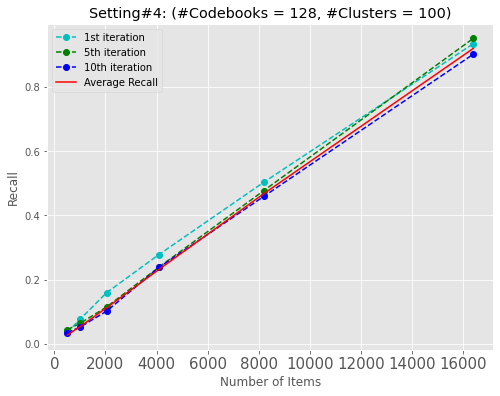

In [437]:
x = [512, 1024, 2048, 4096, 8192, 16384]
firstit = recall_item_curve[1,:]
fifthit = recall_item_curve[5,:]
tenthit = recall_item_curve[9,:]
recall_Set.append(recall_item_curve[:,11:15])
recall_average = recall_item_curve.mean(axis=0)
plt.rc('axes', titlesize=25, labelsize = 15)
plt.rc('xtick', labelsize=15)
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(x,firstit[9:15], 'co--',label='1st iteration')
plt.plot(x,fifthit[9:15], 'go--',label = '5th iteration')
plt.plot(x,tenthit[9:15], 'bo--',label = '10th iteration')
plt.plot(x, recall_average[9:15], 'r', label = 'Average Recall')
plt.xlabel('Number of Items')
plt.ylabel('Recall')
plt.legend()
plt.grid("True")
plt.title("Setting#%s: (#Codebooks = %s, #Clusters = %s)" % (pi+1, cs[pi], ks[pi]))
plt.savefig("setting%s.png" % (pi+1),dpi=900)
plt.show()

In [438]:
average_time[pi] = round((np.mean(time_list)),2)
average_std[pi] = round((recall_item_curve.std()),2)

In [439]:
average_time

[7.6, 7.76, 11.67, 18.13]

In [440]:
average_std

[0.32, 0.32, 0.32, 0.32]

In [441]:
recall_numbers = np.array(recall_Set)
print(recall_numbers.mean(axis=1))

[[0.110935 0.23366  0.473895 0.916175]
 [0.10823  0.232615 0.472625 0.91457 ]
 [0.110735 0.230855 0.47113  0.916815]
 [0.11213  0.231655 0.46713  0.919165]]


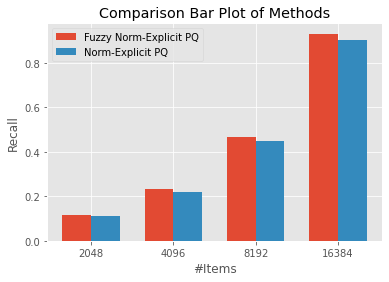

In [9]:
rf=[0.118, 0.234, 0.468, 0.931]
r = [0.110, 0.220, 0.450, 0.904]
plt.style.use('ggplot')
index = np.arange(4)
bar_width = 0.35

fig, ax = plt.subplots()
fuzzy_norm = ax.bar(index, rf, bar_width,
                label="Fuzzy Norm-Explicit PQ")

norm = ax.bar(index+bar_width, r,
                 bar_width, label="Norm-Explicit PQ")

ax.set_xlabel('#Items')
ax.set_ylabel('Recall')
ax.set_title('Comparison Bar Plot of Methods')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([2048, 4096, 8192, 16384])
ax.legend()
plt.savefig('comparison_barplot.png', dpi=900)
plt.show()